In [304]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import sigmaclip
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, mean_squared_error
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree, export_graphviz
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, LassoLars, ElasticNet, Lars, BayesianRidge, Lasso, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, BaggingRegressor, GradientBoostingRegressor, AdaBoostRegressor, StackingRegressor, GradientBoostingClassifier, AdaBoostClassifier, StackingClassifier

# Для третьей работы

In [197]:
data_train = pd.read_csv('./practice3/data/train.csv')
data_test = pd.read_csv('./practice3/data/test.csv')

In [198]:
def perform_change(ar):
    uniq_val = ar.unique()
    decoder = {}
    count = 1
    for i in uniq_val:
        if pd.isna(i):
            decoder[count] = i
            count += 1
            continue
        ar.replace(i, count, inplace=True)
        decoder[count] = i
        count += 1
    return decoder

def perform_decoder(ar, decoder):
    for key, value in decoder.items():
        ar.replace(key, value, inplace=True)

## Обработка данных

In [199]:
knnimpute_data = data_train[['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Embarked']].copy()

# Закодируем категориальные столбцы
decoder_sex = perform_change(knnimpute_data['Sex'])
decoder_embarked = perform_change(knnimpute_data['Embarked'])

knn = KNNImputer(n_neighbors=5, weights='distance')

scaler = StandardScaler()

knnimpute_data = scaler.fit_transform(knnimpute_data) # стандартизируем

knnimpute_data_imputed_temp = knn.fit_transform(knnimpute_data) # заполняем

knnimpute_data = scaler.inverse_transform(knnimpute_data_imputed_temp)

knnimpute_data = pd.DataFrame(knnimpute_data)
knnimpute_data = knnimpute_data[[3]].astype(int)

data_train['Age'] = knnimpute_data.values

In [200]:
knnimpute_data = data_test[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Embarked']].copy()

# Закодируем категориальные столбцы
decoder_sex = perform_change(knnimpute_data['Sex'])
decoder_embarked = perform_change(knnimpute_data['Embarked'])

knnimpute_data = scaler.fit_transform(knnimpute_data) # стандартизируем

knnimpute_data_imputed_temp = knn.fit_transform(knnimpute_data) # заполняем

knnimpute_data = scaler.inverse_transform(knnimpute_data_imputed_temp)

knnimpute_data = pd.DataFrame(knnimpute_data)
knnimpute_data = knnimpute_data[[2]].astype(int)

data_test['Age'] = knnimpute_data.values

In [201]:
data_train.drop(['Name', 'Cabin', 'Ticket', 'PassengerId'], axis=1, inplace=True)

In [202]:
data_test.drop(['Name', 'Cabin', 'Ticket'], axis=1, inplace=True)

In [203]:
decoder_sex = perform_change(data_train['Sex'])
decoder_emb = perform_change(data_train['Embarked'])

In [204]:
data_test.replace(np.nan, data_test['Embarked'].mode()[0], inplace=True)

In [205]:
decoder_sex_t = perform_change(data_test['Sex'])
decoder_emb_t = perform_change(data_test['Embarked'])

In [206]:
values_of_sigmaclip = sigmaclip(data_train['Fare'], low=1, high=4)

print(f"Нижняя граница Fare: {values_of_sigmaclip.lower}")
print(f"Верхняя граница Fare: {values_of_sigmaclip.upper}")

data_train = data_train[data_train['Fare'].isin(values_of_sigmaclip.clipped)]

Нижняя граница Fare: -0.8014583929911474
Верхняя граница Fare: 123.35064276961627


In [207]:
data_train = data_train[(data_train['Fare'] != 0) & (data_train['Age'] != 0)]

In [208]:
columns_to_scale = ['Age', 'Fare']
data_st = data_train[columns_to_scale]
data_scaled = scaler.fit_transform(data_st)
data_train[columns_to_scale] = data_scaled

In [209]:
data_st_t = data_test[columns_to_scale]
data_scaled_t = scaler.fit_transform(data_st_t)
data_test[columns_to_scale] = data_scaled_t

In [210]:
x = data_train.drop(columns=['Survived'])
y = data_train['Survived']

In [211]:
print(x)
print(y)

     Pclass  Sex       Age  SibSp  Parch      Fare  Embarked
0         3    1 -1.734222      3      1  0.037297         1
1         3    2 -0.231797      0      0 -0.692190         1
3         2    1 -0.374885      0      2 -0.401864         1
4         2    2 -2.020398      2      1  0.579238         1
6         3    2 -0.231797      2      0 -0.635627         1
..      ...  ...       ...    ...    ...       ...       ...
529       3    1 -1.948854      3      2  0.134739         1
530       3    1 -1.877310      3      1 -0.138568         1
531       3    2 -1.662678      3      1  0.037297         1
532       2    1 -0.374885      2      3 -0.231673         1
533       1    2  1.342172      0      0  0.080678         1

[496 rows x 7 columns]
0      0
1      0
3      1
4      1
6      0
      ..
529    0
530    0
531    0
532    1
533    1
Name: Survived, Length: 496, dtype: int64


In [212]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

## Построение композиций алгоритмов

### Бэггинг

Оптимальное количество моделей: 5
Лучший результат на контрольной выборке: 10


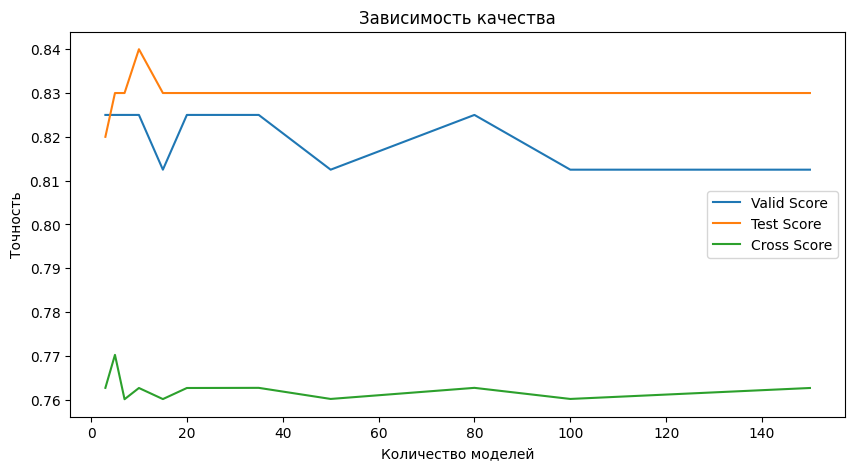

In [229]:
n_estimators = [3, 5, 7, 10, 15, 20, 35, 50, 80, 100, 150]

valid_scores = []
test_scores = []

param_grid = {'n_estimators': n_estimators}

x_train_crop, x_test_crop, y_train_crop, y_test_crop = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

bagging = BaggingClassifier(estimator=LogisticRegression(C=0.1), random_state=42)
grid_search = GridSearchCV(bagging, param_grid, cv=5, scoring='accuracy')
grid_search.fit(x_train, y_train)

grid_scores = grid_search.cv_results_['mean_test_score']
best_n_est = grid_search.best_params_['n_estimators']
print(f'Оптимальное количество моделей: {best_n_est}')

for n in n_estimators:
    bagging = BaggingClassifier(estimator=LogisticRegression(C=0.1), n_estimators=n, random_state=42)
    bagging.fit(x_train_crop, y_train_crop)
    valid_scores.append(bagging.score(x_test_crop, y_test_crop))
    test_scores.append(bagging.score(x_test, y_test))

print(f'Лучший результат на контрольной выборке: {n_estimators[test_scores.index(max(test_scores))]}')

plt.figure(figsize=(10, 5))
plt.plot(n_estimators, valid_scores, label='Valid Score')
plt.plot(n_estimators, test_scores, label='Test Score')
plt.plot(n_estimators, grid_scores, label='Cross Score')
plt.xlabel('Количество моделей')
plt.ylabel('Точность')
plt.title('Зависимость качества от параметров')
plt.legend()
plt.show()

In [230]:
best_bagging = grid_search.best_estimator_

data_test['Survived'] = np.nan
x_test_t = data_test.drop(['PassengerId', 'Survived'], axis=1)
y_pred_test = best_bagging.predict(x_test_t)
data_test['Survived'] = y_pred_test
data_test_response = data_test[['PassengerId', 'Survived']]
data_test_response.to_csv('bagging.csv', index=False)


Результаты kaggle:

обычная логисчтическая регрессия: 0.79147

одиночное дерево с оптимальной глубиной(3): 0.77725

логистическая регрессия c бэггингом: 0.81943

### Бустинг

Оптимальное количество моделей: 10
Лучший результат на контрольной выборке: 7


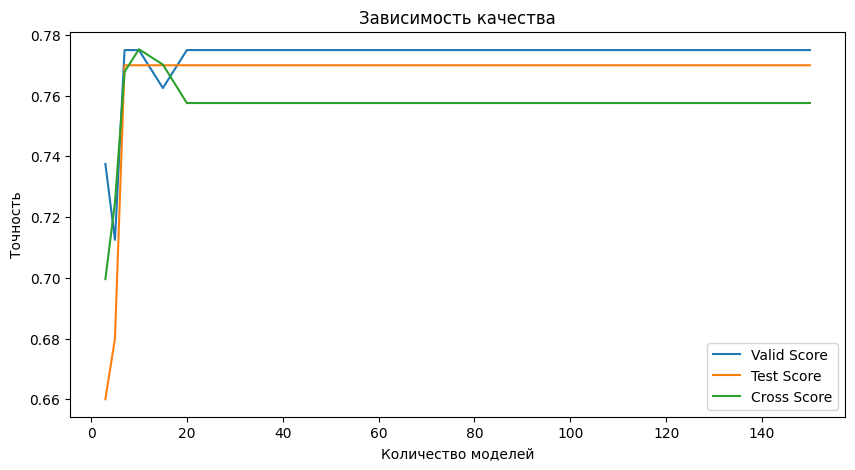

In [233]:
n_estimators = [3, 5, 7, 10, 15, 20, 35, 50, 80, 100, 150]

valid_scores = []
test_scores = []

gb = AdaBoostClassifier(estimator=LogisticRegression(C=0.1), random_state=42, algorithm='SAMME')
grid_search_gb = GridSearchCV(estimator=gb, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search_gb.fit(x_train, y_train)

grid_scores = grid_search_gb.cv_results_['mean_test_score']
best_n_est = grid_search_gb.best_params_['n_estimators']
print(f'Оптимальное количество моделей: {best_n_est}')


for n in n_estimators:
    gb = AdaBoostClassifier(estimator=LogisticRegression(C=0.1), n_estimators=n, random_state=42, algorithm='SAMME')
    gb.fit(x_train_crop, y_train_crop)
    valid_scores.append(gb.score(x_test_crop, y_test_crop))
    test_scores.append(gb.score(x_test, y_test))

print(f'Лучший результат на контрольной выборке: {n_estimators[test_scores.index(max(test_scores))]}')

plt.figure(figsize=(10, 5))
plt.plot(n_estimators, valid_scores, label='Valid Score')
plt.plot(n_estimators, test_scores, label='Test Score')
plt.plot(n_estimators, grid_scores, label='Cross Score')
plt.xlabel('Количество моделей')
plt.ylabel('Точность')
plt.title('Зависимость качества от параметров')
plt.legend()
plt.show()

In [234]:
best_boost = grid_search_gb.best_estimator_

data_test['Survived'] = np.nan
x_test_t = data_test.drop(['PassengerId', 'Survived'], axis=1)
y_pred_test = best_boost.predict(x_test_t)
data_test['Survived'] = y_pred_test
data_test_response = data_test[['PassengerId', 'Survived']]
data_test_response.to_csv('boost.csv', index=False)

Результаты kaggle:

обычная логисчтическая регрессия: 0.79147

одиночное дерево с оптимальной глубиной(3): 0.77725

логистическая регрессия с бустингом: 0.83329

### Стэкинг

In [244]:
estimators = [
    ('dt', DecisionTreeClassifier(max_depth=3, random_state=42)),
    ('lr', LogisticRegression(C=0.1)),
    ('rf', RidgeClassifier()),
    ('rfc', RandomForestClassifier(n_estimators=7, random_state=42)),
    ('bg', best_bagging),
    ('boost', best_boost)
]

stacking_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(C=0.1)
)

stacking_clf.fit(x_train, y_train)

y_pred_clf = stacking_clf.predict(x_test)
print(f'Accuracy: {accuracy_score(y_test, y_pred_clf)}')

Accuracy: 0.84


In [247]:
data_test['Survived'] = np.nan
x_test_t = data_test.drop(['PassengerId', 'Survived'], axis=1)
y_pred_test = stacking_clf.predict(x_test_t)
data_test['Survived'] = y_pred_test
data_test_response = data_test[['PassengerId', 'Survived']]
data_test_response.to_csv('stacking.csv', index=False)

kaggle score: 0.81038

# Для четвертой работы

## Обработка данных

In [277]:
data_train = pd.read_csv('./practice4/data/train.csv')
data_test = pd.read_csv('./practice4/data/test.csv')

In [278]:
data_train.drop(columns=['Без.ремонта', 'Иные.перекрытия', 'Смешанные.стены'], inplace=True)
all_features_set = ['Монолитные.стены', 'Кирпичные.стены', 'Банк.1000', 'Кафе.1000', 'Панельные.стены', 'Смешанные.перекрытия', 'id', 'Деревянные.стены', 'Парковка', 'АЗС.1000', 'Бар.1000', 'Школа.1000']
data_train.drop(columns=all_features_set, inplace=True)

In [279]:
X = data_train.drop(columns=['Цена'])
Y = data_train['Цена']

selected_features = ['Общая.площадь', 'Стоматология.1000', 'Год.постройки', 'Евроремонт', 'Остановка.1000', 'ВУЗ.1000', 'ТЦ.1000', 'Этаж', 'Одежда..1000', 'Косметический', 'Дизайнерский', 'Количество.комнат', 'Почта.1000', 'Супер3кет.1000']

x_train_r, x_test_r, y_train_r, y_test_r = train_test_split(X, Y, test_size=0.2, random_state=42)

x_train_r = x_train_r[selected_features]
x_test_r = x_test_r[selected_features]

## Построение композиций алгоритмов

### Бэггинг

Оптимальное количество моделей: 150
Лучший результат на контрольной выборке: 15


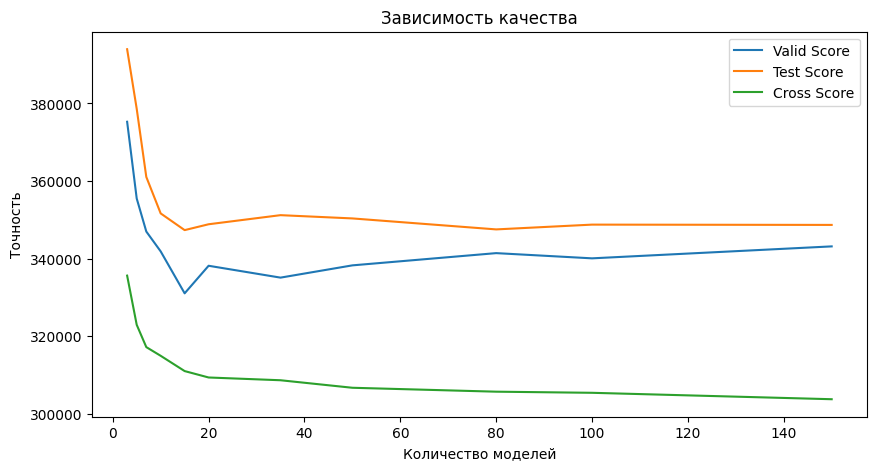

In [293]:
n_estimators = [3, 5, 7, 10, 15, 20, 35, 50, 80, 100, 150]

param_grid_reg = {'n_estimators': n_estimators}

valid_scores_reg = []
test_scores_reg = []

x_train_crop_r, x_test_crop_r, y_train_crop_r, y_test_crop_r = train_test_split(x_train_r, y_train_r, test_size=0.2, random_state=42)

bagging_r = BaggingRegressor(estimator=DecisionTreeRegressor(max_depth=6, random_state=42), random_state=42)
grid_search_r = GridSearchCV(bagging_r, param_grid_reg, cv=5, scoring='neg_mean_squared_error')
grid_search_r.fit(x_train_r, y_train_r)

grid_scores_reg = np.sqrt(-grid_search_r.cv_results_['mean_test_score'])
best_n_est4 = grid_search_r.best_params_['n_estimators']
print(f'Оптимальное количество моделей: {best_n_est4}')

for n in n_estimators:
    bagging_r = BaggingRegressor(estimator=DecisionTreeRegressor(max_depth=6, random_state=42), n_estimators=n, random_state=42)
    bagging_r.fit(x_train_crop_r, y_train_crop_r)
    y_valid_pred = bagging_r.predict(x_test_crop_r)
    y_test_pred = bagging_r.predict(x_test_r)
    valid_scores_reg.append(np.sqrt(mean_squared_error(y_test_crop_r, y_valid_pred)))
    test_scores_reg.append(np.sqrt(mean_squared_error(y_test_r, y_test_pred)))

print(f'Лучший результат на контрольной выборке: {n_estimators[test_scores_reg.index(min(test_scores_reg))]}')

plt.figure(figsize=(10, 5))
plt.plot(n_estimators, valid_scores_reg, label='Valid Score')
plt.plot(n_estimators, test_scores_reg, label='Test Score')
plt.plot(n_estimators, grid_scores_reg, label='Cross Score')
plt.xlabel('Количество моделей')
plt.ylabel('Точность')
plt.title('Зависимость качества от параметров')
plt.legend()
plt.show()

In [280]:
data_test.drop(columns=['Без.ремонта', 'Иные.перекрытия', 'Смешанные.стены'], inplace=True)
data_T = data_test.drop(columns=all_features_set)

In [285]:
best_bagging_reg = grid_search_r.best_estimator_

predictions_reg = best_bagging_reg.predict(data_T[selected_features])

submission = pd.DataFrame({
    'id': data_test['id'],
    'Цена': predictions_reg
})

submission.to_csv('bagging_reg.csv', index=False)

Результаты kaggle(private_score):

(Из 5 работы) Одиночное дерево с оптимальной глубиной 6: 325082.64418

(Из 4 работы) Линейная регрессия: 313516.02022

Самый лучший результат бэггинга был с деревом с оптимальной глубиной: 270267.31868

### Бустинг

Оптимальное количество моделей: 80
Лучший результат на тестовой выборке: 50


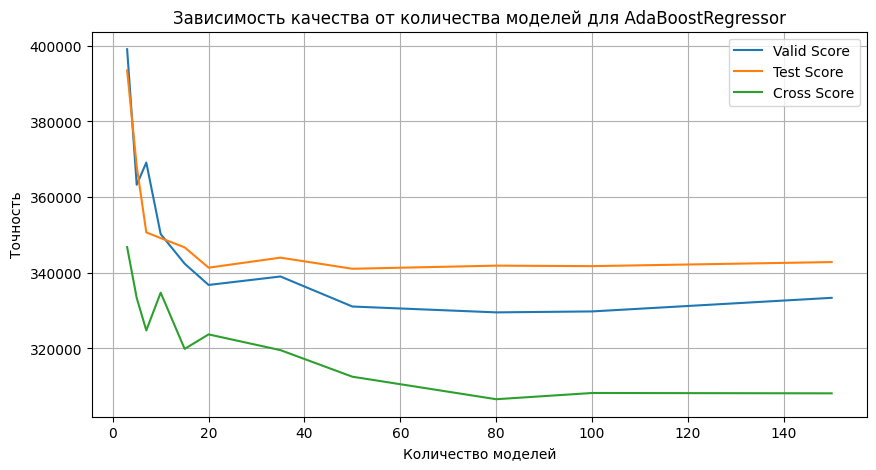

In [300]:
adaboost_r = AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=6, random_state=42), random_state=42)
grid_search_r = GridSearchCV(adaboost_r, param_grid_reg, cv=5, scoring='neg_mean_squared_error')
grid_search_r.fit(x_train_r, y_train_r)

valid_scores_reg = []
test_scores_reg = []

grid_scores_reg = np.sqrt(-grid_search_r.cv_results_['mean_test_score'])
best_n_est4 = grid_search_r.best_params_['n_estimators']
print(f'Оптимальное количество моделей: {best_n_est4}')

for n in n_estimators:
    adaboost_r = AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=6, random_state=42), n_estimators=n, random_state=42)
    adaboost_r.fit(x_train_crop_r, y_train_crop_r)
    y_valid_pred = adaboost_r.predict(x_test_crop_r)
    y_test_pred = adaboost_r.predict(x_test_r)
    valid_scores_reg.append(np.sqrt(mean_squared_error(y_test_crop_r, y_valid_pred)))
    test_scores_reg.append(np.sqrt(mean_squared_error(y_test_r, y_test_pred)))

print(f'Лучший результат на тестовой выборке: {n_estimators[test_scores_reg.index(min(test_scores_reg))]}')

plt.figure(figsize=(10, 5))
plt.plot(n_estimators, valid_scores_reg, label='Valid Score')
plt.plot(n_estimators, test_scores_reg, label='Test Score')
plt.plot(n_estimators, grid_scores_reg, label='Cross Score')
plt.xlabel('Количество моделей')
plt.ylabel('Точность')
plt.title('Зависимость качества от количества моделей для AdaBoostRegressor')
plt.legend()
plt.grid(True)
plt.show()

In [299]:
best_boost_reg = grid_search_r.best_estimator_

predictions_reg = best_boost_reg.predict(data_T[selected_features])

submission = pd.DataFrame({
    'id': data_test['id'],
    'Цена': predictions_reg
})

submission.to_csv('boost_reg.csv', index=False)

Результаты kaggle(private score):

(Из 5 работы) Одиночное дерево с оптимальной глубиной 6: 325082.64418

(Из 4 работы) Линейная регрессия: 313516.020

Бустинг с деревом с оптимальной глубиной: 269357.46907

Бустинг с линейной регрессией: 288621.27384

Бустинг с лассо регрессией: 290166.235802


### Стэкинг

In [303]:
estimators = [
    ('dt', DecisionTreeRegressor(max_depth=6, random_state=42)),
    ('lr', LinearRegression()),
    ('ridge', Ridge(alpha=10)),
    ('rf', RandomForestRegressor(n_estimators=7, random_state=42)),
    ('bg', best_bagging_reg),
    ('boost', best_boost_reg)
]

stacking_reg = StackingRegressor(
    estimators=estimators,
    final_estimator=LinearRegression()
)

stacking_reg.fit(x_train_r, y_train_r)

y_pred_reg = stacking_reg.predict(x_test_r)
rmse = np.sqrt(mean_squared_error(y_test_r, y_pred_reg))
print(f'RMSE: {rmse}')


RMSE: 313915.67583185696


In [302]:
predictions_reg = stacking_reg.predict(data_T[selected_features])

submission = pd.DataFrame({
    'id': data_test['id'],
    'Цена': predictions_reg
})

submission.to_csv('stacking_reg.csv', index=False)

Результат kaggle: 261873.87490